In [3]:
import tensorflow as tf
import numpy as np

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD

In [5]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

In [6]:
from tensorflow.keras.applications import VGG19

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
import matplotlib.pyplot as plt

### Data Loading

In [30]:
# Load CIFAR-10 dataset from Keras
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

### Preprocessing

In [31]:
# Data spliting in Train, Val, Test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [32]:
# Converting labels to one-hot encoder format
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [33]:
print("Train: ", (X_train.shape, y_train.shape))
print("Val: ", (X_val.shape, y_val.shape))
print("Test: ", (X_test.shape, y_test.shape))

Train:  ((37500, 32, 32, 3), (37500, 10))
Val:  ((12500, 32, 32, 3), (12500, 10))
Test:  ((10000, 32, 32, 3), (10000, 10))


### Model Definition

In [54]:
model_vgg = VGG19(weights='imagenet', classes=y_train.shape[1], input_shape=(32,32,3), include_top=False)

### Trainig with Freeze Layers

In [55]:
model_vgg.trainable = False
model_vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [56]:
# Sequential Model
# Adding the pre-trained (vgg19 model) as the first layer
# Add a Global Average Pooling layer to reduce spatial dimensions and provide a global summary of the features
# The input dimension is set to 512 in the first Dense Layer, the pre-trained model has 512 output features

model = Sequential()
model.add(model_vgg)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024,activation=('relu'),input_dim=512))
model.add(Dense(512,activation=('relu')))
model.add(Dropout(0.2))
model.add(Dense(256,activation=('relu')))
model.add(Dropout(0.2))
model.add(Dense(128,activation=('relu')))
model.add(Dense(10,activation=('softmax')))

print("Trainable Variables: ", len(model_vgg.trainable_variables))

Trainable Variables:  0


In [57]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 global_average_pooling2d_3  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_30 (Dense)            (None, 1024)              525312    
                                                                 
 dense_31 (Dense)            (None, 512)               524800    
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_32 (Dense)            (None, 256)               131328    
                                                      

#### Model Training (Freeze Layers)

In [59]:
initial_epochs = 10
history = model.fit(X_train, y_train, epochs=initial_epochs, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
586/586 [==============================] - 14s 20ms/step - loss: 1.6746 - accuracy: 0.4018 - val_loss: 1.3789 - val_accuracy: 0.5146
Epoch 2/10
586/586 [==============================] - 11s 18ms/step - loss: 1.3730 - accuracy: 0.5125 - val_loss: 1.2703 - val_accuracy: 0.5522
Epoch 3/10
586/586 [==============================] - 11s 18ms/step - loss: 1.2851 - accuracy: 0.5475 - val_loss: 1.2348 - val_accuracy: 0.5691
Epoch 4/10
586/586 [==============================] - 11s 18ms/step - loss: 1.2213 - accuracy: 0.5697 - val_loss: 1.2027 - val_accuracy: 0.5776
Epoch 5/10
586/586 [==============================] - 11s 18ms/step - loss: 1.1731 - accuracy: 0.5880 - val_loss: 1.1833 - val_accuracy: 0.5845
Epoch 6/10
586/586 [==============================] - 14s 25ms/step - loss: 1.1349 - accuracy: 0.5999 - val_loss: 1.1529 - val_accuracy: 0.5953
Epoch 7/10
586/586 [==============================] - 11s 18ms/step - loss: 1.0950 - accuracy: 0.6160 - val_loss: 1.1489 - val_accuracy:

#### Model Prediction (Freeze Layers)

In [60]:
loss0, accuracy0 = model.evaluate(X_test, y_test)

313/313 [==============================] - 4s 12ms/step - loss: 1.1323 - accuracy: 0.6028


### Next Training with  Some unfreeze Layers

In [61]:
# Model Fine Tuning True
model_vgg.trainable = True
print("Number of layers in the base model: ", len(model_vgg.layers))

# Fine-tune from this layer onwards
fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in model_vgg.layers[:fine_tune_at]:
    layer.trainable = False

print("Trainable Variables: ", len(model_vgg.trainable_variables))

Number of layers in the base model:  22
Trainable Variables:  10


In [62]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 global_average_pooling2d_3  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_30 (Dense)            (None, 1024)              525312    
                                                                 
 dense_31 (Dense)            (None, 512)               524800    
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_32 (Dense)            (None, 256)               131328    
                                                      

#### Model Training (Some Unfreeze Layers)

In [64]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(X_train, y_train,
                         epochs = total_epochs,
                         batch_size = 64,
                         initial_epoch = history.epoch[-1]+1,
                         validation_data=(X_val, y_val))

Epoch 11/30
586/586 [==============================] - 11s 18ms/step - loss: 0.7962 - accuracy: 0.7208 - val_loss: 1.1622 - val_accuracy: 0.6130
Epoch 12/30
586/586 [==============================] - 11s 18ms/step - loss: 0.7665 - accuracy: 0.7317 - val_loss: 1.1536 - val_accuracy: 0.6161
Epoch 13/30
586/586 [==============================] - 11s 18ms/step - loss: 0.7337 - accuracy: 0.7401 - val_loss: 1.2082 - val_accuracy: 0.6130
Epoch 14/30
586/586 [==============================] - 11s 19ms/step - loss: 0.7003 - accuracy: 0.7529 - val_loss: 1.1720 - val_accuracy: 0.6199
Epoch 15/30
586/586 [==============================] - 11s 18ms/step - loss: 0.6671 - accuracy: 0.7648 - val_loss: 1.2138 - val_accuracy: 0.6170
Epoch 16/30
586/586 [==============================] - 11s 19ms/step - loss: 0.6392 - accuracy: 0.7755 - val_loss: 1.2609 - val_accuracy: 0.6132
Epoch 17/30
586/586 [==============================] - 11s 19ms/step - loss: 0.6075 - accuracy: 0.7866 - val_loss: 1.2421 - val_ac

#### Model Prediction (Some Unfreeze Layers)

In [65]:
loss1, accuracy1 = model.evaluate(X_test, y_test)

313/313 [==============================] - 3s 11ms/step - loss: 1.7534 - accuracy: 0.6027


### Trainig with Some Unfreeze Layers from begineering

In [66]:
# Model Fine Tuning True
model_vgg.trainable = True
print("Number of layers in the base model: ", len(model_vgg.layers))

# Fine-tune from this layer onwards
fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in model_vgg.layers[:fine_tune_at]:
    layer.trainable = False

print("Trainable Variables: ", len(model_vgg.trainable_variables))

Number of layers in the base model:  22
Trainable Variables:  10


In [67]:
# Sequential Model
# Adding the pre-trained (vgg19 model) as the first layer
# Add a Global Average Pooling layer to reduce spatial dimensions and provide a global summary of the features
# The input dimension is set to 512 in the first Dense Layer, the pre-trained model has 512 output features

model_new = Sequential()
model_new.add(model_vgg)
model_new.add(GlobalAveragePooling2D())
model_new.add(Dense(1024,activation=('relu'),input_dim=512))
model_new.add(Dense(512,activation=('relu')))
model_new.add(Dropout(0.2))
model_new.add(Dense(256,activation=('relu')))
model_new.add(Dropout(0.2))
model_new.add(Dense(128,activation=('relu')))
model_new.add(Dense(10,activation=('softmax')))

print("Trainable Variables: ", len(model_vgg.trainable_variables))

Trainable Variables:  10


In [68]:
model_new.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [71]:
model_new.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 global_average_pooling2d_4  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_35 (Dense)            (None, 1024)              525312    
                                                                 
 dense_36 (Dense)            (None, 512)               524800    
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 dense_37 (Dense)            (None, 256)               131328    
                                                      

#### Model Training

In [72]:
history_new = model_new.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/20
586/586 [==============================] - 23s 34ms/step - loss: 1.1812 - accuracy: 0.5919 - val_loss: 0.9102 - val_accuracy: 0.6842
Epoch 2/20
586/586 [==============================] - 19s 32ms/step - loss: 0.8364 - accuracy: 0.7211 - val_loss: 0.8396 - val_accuracy: 0.7203
Epoch 3/20
586/586 [==============================] - 20s 35ms/step - loss: 0.7050 - accuracy: 0.7635 - val_loss: 0.7809 - val_accuracy: 0.7368
Epoch 4/20
586/586 [==============================] - 20s 33ms/step - loss: 0.5796 - accuracy: 0.8058 - val_loss: 0.7754 - val_accuracy: 0.7498
Epoch 5/20
586/586 [==============================] - 19s 33ms/step - loss: 0.4798 - accuracy: 0.8391 - val_loss: 0.7608 - val_accuracy: 0.7559
Epoch 6/20
586/586 [==============================] - 19s 33ms/step - loss: 0.3880 - accuracy: 0.8691 - val_loss: 0.7961 - val_accuracy: 0.7654
Epoch 7/20
586/586 [==============================] - 20s 35ms/step - loss: 0.3017 - accuracy: 0.9001 - val_loss: 0.8713 - val_accuracy:

#### Model Prediction

In [73]:
loss, accuracy = model_new.evaluate(X_test, y_test)

313/313 [==============================] - 3s 11ms/step - loss: 1.2929 - accuracy: 0.7508


### Model Evaluation

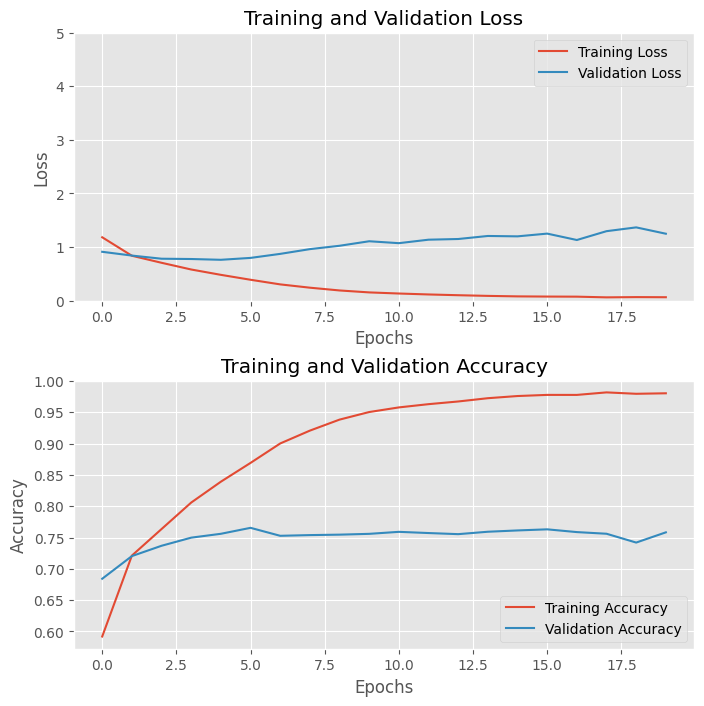

In [75]:
# Ploting Accuracy and Loss (Training and Validation)

acc = history_new.history['accuracy']
val_acc = history_new.history['val_accuracy']
loss = history_new.history['loss']
val_loss = history_new.history['val_loss']

plt.style.use('ggplot')
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')

plt.subplot(2, 1, 2)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplots_adjust(hspace=0.3) # Gap between suplots
plt.show()

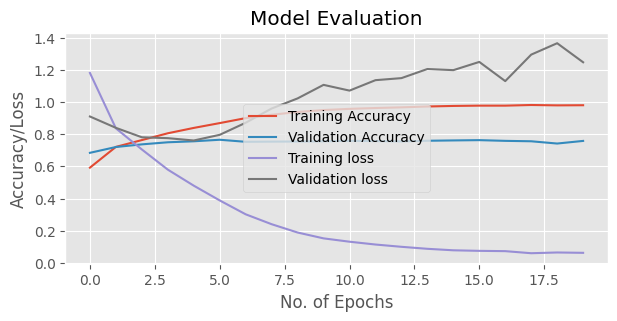

In [79]:
#All in one Graph (loss and accuracy)
plt.style.use('ggplot')
plt.figure(figsize=(7, 3))
plt.plot(history_new.history["accuracy"])
plt.plot(history_new.history["val_accuracy"])
plt.plot(history_new.history["loss"])
plt.plot(history_new.history["val_loss"])
plt.title("Model Evaluation")
plt.ylabel("Accuracy/Loss")
plt.xlabel("No. of Epochs")
plt.legend(["Training Accuracy","Validation Accuracy","Training loss","Validation loss"], loc='center')
plt.show()

### Model from Scratch

In [92]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

In [93]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
hitory = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
586/586 [==============================] - 13s 21ms/step - loss: 1.4908 - accuracy: 0.4637 - val_loss: 1.1918 - val_accuracy: 0.5816
Epoch 2/10
586/586 [==============================] - 12s 20ms/step - loss: 1.1048 - accuracy: 0.6135 - val_loss: 1.0355 - val_accuracy: 0.6446
Epoch 3/10
586/586 [==============================] - 12s 20ms/step - loss: 0.9289 - accuracy: 0.6754 - val_loss: 0.9289 - val_accuracy: 0.6774
Epoch 4/10
586/586 [==============================] - 12s 20ms/step - loss: 0.8137 - accuracy: 0.7158 - val_loss: 0.8734 - val_accuracy: 0.7035
Epoch 5/10
586/586 [==============================] - 12s 20ms/step - loss: 0.7006 - accuracy: 0.7541 - val_loss: 0.8594 - val_accuracy: 0.7090
Epoch 6/10
586/586 [==============================] - 11s 20ms/step - loss: 0.6034 - accuracy: 0.7883 - val_loss: 0.8652 - val_accuracy: 0.7114
Epoch 7/10
586/586 [==============================] - 11s 19ms/step - loss: 0.5161 - accuracy: 0.8181 - val_loss: 0.8818 - val_accuracy:

In [94]:
# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

313/313 [==============================] - 2s 5ms/step - loss: 1.0624 - accuracy: 0.7001
Test loss: 1.0624085664749146
Test accuracy: 0.7001000046730042


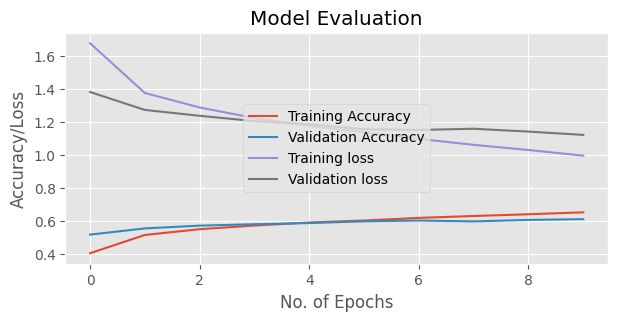

In [95]:
#All in one Graph (loss and accuracy)
plt.style.use('ggplot')
plt.figure(figsize=(7, 3))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Evaluation")
plt.ylabel("Accuracy/Loss")
plt.xlabel("No. of Epochs")
plt.legend(["Training Accuracy","Validation Accuracy","Training loss","Validation loss"], loc='center')
plt.show()